# Import

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tight_subplot as ts

# Problem 1:

Load the provided image “texture.jpeg” and convert it to grayscale. Write code for a Gaussian and Laplacian pyramid of 5 levels (use for loops). At each level, the resolution should be reduced by a factor of 2. Show your pyramids and include the code in your submission.

483 743


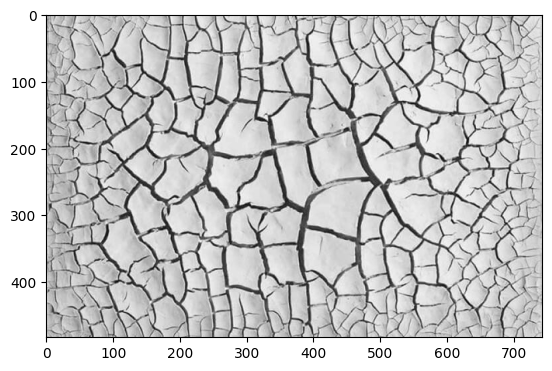

In [45]:
# Convert to gray scale
texture_img = cv2.imread('texture.jpeg')
texture_img_yuv = cv2.cvtColor(texture_img, cv2.COLOR_BGR2YUV)
texture_y, texture_u, texture_v = cv2.split(texture_img_yuv)
# display the Y component in notebook
plt.imshow(texture_y, cmap='gray')
X, Y, Z = texture_img.shape
print(X, Y)

## Part 1: 
Display a Gaussian and Laplacian pyramid of level 5 (write your code). It should be formatted
similarly to Figure 1 above. You may find the included “tight_subplot.py” helpful for making plots.

### Gaussian and Laplacian Pyramid

In [80]:
# downsampling rate is 2
# so sigma = sqrt(2/2) = 1
gaussian_images = []
laplacian_images = []
gaussian_kernel = cv2.getGaussianKernel(3, 1)
prefilter_y = texture_y
for i in range(5):
    # filter
    filtered_y = cv2.filter2D(prefilter_y, -1, gaussian_kernel)
    gaussian_images.append(filtered_y)
    # compute residual
    residual = prefilter_y - filtered_y
    laplacian_images.append(residual)
    # downsample filtered image
    downsampled_y = cv2.resize(filtered_y, (0, 0), fx=0.5, fy=0.5)
    prefilter_y = downsampled_y


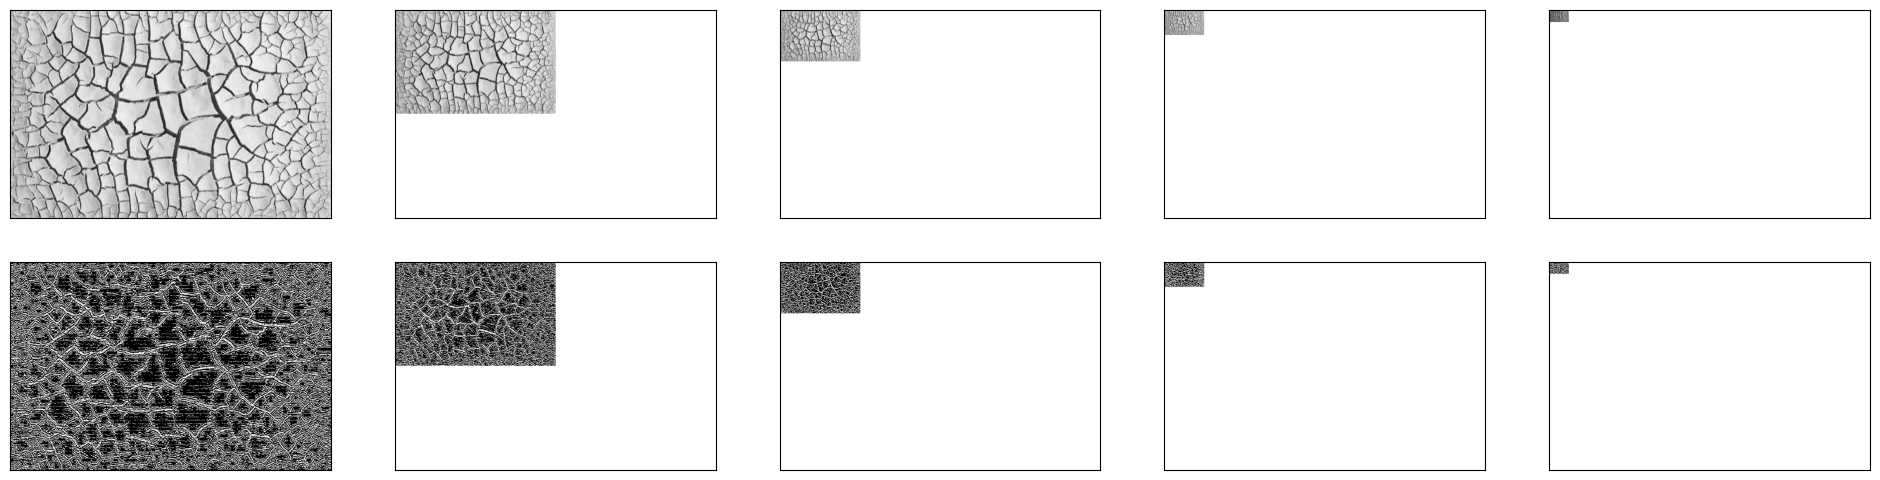

In [81]:
# Display Pyramid
padded_gaussian_images = []
padded_laplacian_images = []
for i in range(5):
    gaussian_image = gaussian_images[i]
    laplacian_image = laplacian_images[i]

    pad_right = Y - gaussian_image.shape[1]
    pad_bottom = X - gaussian_image.shape[0]
    padded_gaussian_image = cv2.copyMakeBorder(gaussian_image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    padded_gaussian_images.append(padded_gaussian_image)

    pad_right = Y - laplacian_image.shape[1]
    pad_bottom = X - laplacian_image.shape[0]
    padded_laplacian_image = cv2.copyMakeBorder(laplacian_image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    padded_laplacian_images.append(padded_laplacian_image)

ts.tight_subplot_2x5(padded_gaussian_images, padded_laplacian_images)
